In [61]:
# https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

200


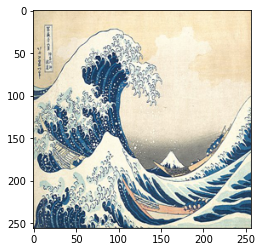

200


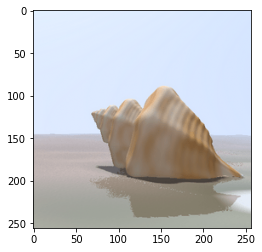

In [62]:
import requests

def image_loader(url, filename):
    req = requests.get(url, headers={
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36',
        'accept': '*/*',
        'accept-language': 'en-US,en;q=0.5',
        'cache-control': 'no-cache',
        'content-type': 'application/x-www-form-urlencoded',
        'pragma': 'no-cache'
    })
    print(req.status_code)
    with open(filename, 'wb') as fp:
        fp.write(req.content)
    image = Image.open(filename).convert("RGB")
    image = np.array(image.resize((256, 256))) / 255.0
    plt.imshow(image)
    plt.show()
    image = np.einsum('abc->cab', image)
    image = torch.tensor(image).unsqueeze(0)
    image = image.contiguous()  # https://discuss.pytorch.org/t/error-when-running-lbfgs-to-solve-a-non-linear-inverse-problem/99911/3
    image = image.to(device, torch.float)
    return image


preset = [
    # Desmos "Ammonite" in the style of "The Great Waves"
    (
        "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/525px-Tsunami_by_hokusai_19th_century.jpg",
        "https://saved-work.desmos.com/calc_thumbs/production/z7zooq9zsh.png"
    ),
    # "Functional Conch" in the style of "The Great Waves"
    (
        "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/525px-Tsunami_by_hokusai_19th_century.jpg",
        "https://cdn.discordapp.com/attachments/987164635872526407/993715550226227200/profile-conch-256-256.png"
    ),
    # "Functional Conch" in the style of "A Sunday on La Grande Jatte"
    (
        "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/A_Sunday_on_La_Grande_Jatte%2C_Georges_Seurat%2C_1884.jpg/1280px-A_Sunday_on_La_Grande_Jatte%2C_Georges_Seurat%2C_1884.jpg",
        "https://cdn.discordapp.com/attachments/987164635872526407/993715550226227200/profile-conch-256-256.png"
    ),
    # "Functional Conch" in the style of "The Starry Night" by Van Gogh
    (
        "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/405px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg",
        "https://cdn.discordapp.com/attachments/987164635872526407/993715550226227200/profile-conch-256-256.png"
    ),
    # "Triangled" in the style of "The Great Waves"
    (
        "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/525px-Tsunami_by_hokusai_19th_century.jpg",
        "https://cdn.discordapp.com/attachments/931320571453653072/1002723816478347274/unknown.png"
    ),
    # "Functional Conch" in the style of "Shot Marilyns" by Andy Warhol
    (
        "https://upload.wikimedia.org/wikipedia/en/5/5c/Shot_Marilyns.jpg",
        "https://cdn.discordapp.com/attachments/987164635872526407/993715550226227200/profile-conch-256-256.png"
    ),
    # "Functional Conch" in the style of "Guernica" by Picasso
    (
        "https://upload.wikimedia.org/wikipedia/en/7/74/PicassoGuernica.jpg",
        "https://cdn.discordapp.com/attachments/987164635872526407/993715550226227200/profile-conch-256-256.png"
    ),
    # "Functional Conch" in the style of "Mona Lisa" by Da Vinci
    (
        "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1200px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg",
        "https://cdn.discordapp.com/attachments/987164635872526407/993715550226227200/profile-conch-256-256.png"
    ),
    # Human in the style of anime
    (
        "https://www.thiswaifudoesnotexist.net/example-50477.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Woman_1.jpg/330px-Woman_1.jpg"
    ),
    # Anime in the style of human
    (
        "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Woman_1.jpg/330px-Woman_1.jpg",
        "https://www.thiswaifudoesnotexist.net/example-50477.jpg"
    )
][1]

style_img = image_loader(preset[0], "style.jpg")
content_img = image_loader(preset[1], "content.jpg")


In [63]:
# content loss, MSE

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input


In [64]:
# style loss

# I don't get what the heck is this...
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input


In [65]:
# Pre-trained model

# We will use the features module because we need the output of the individual convolution layers
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# The network is trained on batch normalized images
# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


In [66]:
# Create model and loss

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4', 'conv_5']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization().to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses


Building the style transfer model..
Optimizing..
run [50]: Style Loss: 0.641238 Content Loss: 1.592078
run [100]: Style Loss: 0.273970 Content Loss: 1.409996
run [150]: Style Loss: 0.181131 Content Loss: 1.310719
run [200]: Style Loss: 0.118968 Content Loss: 1.253291
run [250]: Style Loss: 0.084238 Content Loss: 1.217556
run [300]: Style Loss: 0.071567 Content Loss: 1.191770
run [350]: Style Loss: 0.068428 Content Loss: 1.175239
run [400]: Style Loss: 0.066400 Content Loss: 1.163765
run [450]: Style Loss: 0.065828 Content Loss: 1.155261
run [500]: Style Loss: 0.065090 Content Loss: 1.149474


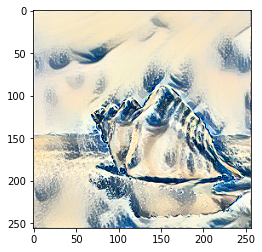

In [67]:
def run_style_transfer(cnn, content_img, style_img, input_img,
                       num_steps=500, style_weight=1e3, content_weight=1e-2):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, style_img, content_img)
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    optimizer = optim.LBFGS([input_img])

    sigmoid = nn.Sigmoid()

    def closure():
        optimizer.zero_grad()
        model(sigmoid(input_img))

        style_score = 0.0
        content_score = 0.0
        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight
        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print("run {}:".format(run), end=' ')
            print('Style Loss: {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
        return style_score + content_score

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        optimizer.step(closure)

    return sigmoid(input_img)


#input_img = content_img.clone()
input_img = torch.rand(content_img.data.size(), device=device)

output = run_style_transfer(cnn, content_img, style_img, input_img)
output = output.cpu().detach().numpy()
output = np.einsum("abcd->cdb", output)
plt.figure()
plt.imshow(output)
plt.show()
